# DATS 6103 Project 3 - Diabetes Patients

Dai Wei Tsang, Fall 2020<a id='top'></a>

# Table of Contents

1. [Motivation and Questions](#one)
2. [Dataset Source and Cleaning](#two)
3. [Analysis](#three)
4. [Conclusions](#four)
5. [Publications](#five)

## 1. Motivation and Questions <a id='one'></a>

According to the CDC, over 34 million Americans have diabetes, just a little over 1 person among every 10.<br>In light of this prevalence, I wanted to answer the following questions:

* Which demographic groups are overrepresented among diabetes patients?


* What are the diseases that tend to be co-morbid with diabetes?


* Which demographics have higher morality rates??


* Is there demographic bias in the care received?


* Does a longer hospital stay reduce later readmission?


* What do the records of the "most problematic" patients look like?

<br>

## 2. Dataset Source and Cleaning <a id='two'></a>

This dataset was imported without any changes from the UC Irvine Machine Learning Repository, accessible [here.](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008)

The original data was extracted from the Health Facts database, a voluntary program offered to organizations which use the Cerner Electronic Health Record System. Clinical care data was collected from 130 hospitals and integrated delivery networks throughout the U.S., from 1999 - 2008. Only inpatient visits where the patient had diabetes as an existing condition were included. More details on the data selection methodology can be accessed [here.](https://www.hindawi.com/journals/bmri/2014/781670/)

In [1]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import plotly as px
from matplotlib import pyplot as plt
import warnings
import seaborn as sns
from math import pi
from matplotlib import rcParams

warnings.filterwarnings('ignore')

In [2]:
diabetic = pd.read_csv('diabetic_data.csv')

In [3]:
#remove columns that contain too many NA values

diabetic = diabetic.drop(['weight', 'payer_code', 'medical_specialty'], axis = 1) 

In [4]:
#remove rows that code for Null, Not Mapped, or Not Available entries

d1 = diabetic[diabetic.admission_type_id != 5|6|8]
d2 = d1[d1.discharge_disposition_id != 18|25|26]
d3 = d2[d2.admission_source_id != 9|15|17|20|21]

d4 = d3[d3.race != '?']
d5 = d4[d4.gender != 'Unknown/Invalid']

In [5]:
#rename columns for ease of understanding

d5 = d5.rename(columns={'admission_type_id':'admit_type',
                        'discharge_disposition_id':'discharge_dispo',
                        'admission_source_id':'admit_source',
                        'time_in_hospital':'days_hospital',
                        'num_lab_procedures':'num_lab_procedures',
                        'num_procedures':'num_other_procedures',
                        'num_medications':'num_meds',
                        'number_outpatient': 'num_outpatient', 
                        'number_emergency':'num_emergency', 
                        'number_inpatient':'num_inpatient',
                        'number_diagnoses':'num_diag',
                        'A1Cresult':'HbA1c_result',
                        'diabetesMed': 'diab_med_prescr',
                        'readmitted':'readmit',
                        'glyburide-metformin': 'glyburide_metformin', 
                        'glipizide-metformin': 'glipizide_metformin', 
                        'glimepiride-pioglitazone': 'glimepiride_pioglitazone', 
                        'metformin-rosiglitazone': 'metformin_rosiglitazone', 
                        'metformin-pioglitazone': 'metformin_pioglitazone'})

In [6]:
#convert data types

d5['age'] = d5['age'].replace(['[0-10)'], '0-10')
d5['age'] = d5['age'].replace(['[10-20)'], '10-20')
d5['age'] = d5['age'].replace(['[20-30)'], '20-30')
d5['age'] = d5['age'].replace(['[30-40)'], '30-40')
d5['age'] = d5['age'].replace(['[40-50)'], '40-50')
d5['age'] = d5['age'].replace(['[50-60)'], '50-60')
d5['age'] = d5['age'].replace(['[60-70)'], '60-70')
d5['age'] = d5['age'].replace(['[70-80)'], '70-80')
d5['age'] = d5['age'].replace(['[80-90)'], '80-90')
d5['age'] = d5['age'].replace(['[90-100)'], '90-100')

In [7]:
#remove rows where the diagnosis is NA or not numeric

col_1 = ['diag_1']

d6 = (d5.drop(col_1, axis=1)
      .join(d5[col_1].apply(pd.to_numeric, errors='coerce')))

d7 = d6[d6[col_1].notnull().all(axis=1)]


col_2 = ['diag_2']

d8 = (d7.drop(col_2, axis=1)
      .join(d7[col_2].apply(pd.to_numeric, errors='coerce')))

d9 = d8[d8[col_2].notnull().all(axis=1)]


col_3 = ['diag_3']

d10 = (d9.drop(col_3, axis=1)
      .join(d9[col_3].apply(pd.to_numeric, errors='coerce')))

d11 = d10[d10[col_3].notnull().all(axis=1)]

In [8]:
#rearrange columns to leave all prescription columns for last

cols = list(d11.columns.values)
encounters = d11[['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'admit_type', 'discharge_dispo', 'admit_source',
            'days_hospital', 'num_lab_procedures', 'num_other_procedures', 'num_meds', 'num_outpatient', 'num_emergency',
            'num_inpatient', 'diag_1', 'diag_2', 'diag_3', 'num_diag', 'max_glu_serum', 'HbA1c_result', 'change',
            'diab_med_prescr', 'readmit', 'insulin', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
            'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone',
            'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 
            'glyburide_metformin', 'glipizide_metformin', 'glimepiride_pioglitazone', 'metformin_rosiglitazone',
            'metformin_pioglitazone',]]

encounters = encounters.reset_index(drop=True)

In [9]:
#create new df containing the first visit for each unique patient

patients = encounters.drop_duplicates(subset='patient_nbr', keep='first')

In [10]:
#save both dfs to new csv file to simplify processing

encounters.to_csv('Encounters.csv', index=False)
patients.to_csv('Patients.csv', index=False)

<br>

## 3. Analysis <a id='three'></a>

In [11]:
# read in new encounters csv

enc = pd.read_csv('Encounters.csv')
enc

,encounter_id,patient_nbr,race,gender,age,admit_type,discharge_dispo,admit_source,days_hospital,num_lab_procedures,num_other_procedures,num_meds,num_outpatient,num_emergency,num_inpatient,diag_1,diag_2,diag_3,num_diag,max_glu_serum,HbA1c_result,change,diab_med_prescr,readmit,insulin,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone
0,149190,55629189,Caucasian,Female,10-20,1,1,7,3,59,0,18,0,0,0,276.00,250.01,255.0,9,None,None,Ch,Yes,>30,Up,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
1,500364,82442376,Caucasian,Male,30-40,1,1,7,2,44,1,16,0,0,0,8.00,250.43,403.0,7,None,None,Ch,Yes,NO,Up,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
2,16680,42519267,Caucasian,Male,40-50,1,1,7,1,51,0,8,0,0,0,197.00,157.00,250.0,5,None,None,Ch,Yes,NO,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
3,35754,82637451,Caucasian,Male,50-60,2,1,2,3,31,6,16,0,0,0,414.00,411.00,250.0,9,None,None,No,Yes,>30,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
4,63768,114882984,Caucasian,Male,70-80,1,1,7,5,73,0,12,0,0,0,428.00,492.00,250.0,8,None,None,No,Yes,>30,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89772,443847548,100162476,AfricanAmerican,Male,70-80,1,3,7,3,51,0,16,0,0,0,250.13,291.00,458.0,9,None,>8,Ch,Yes,>30,Down,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
89773,443847782,74694222,AfricanAmerican,Female,80-90,1,4,5,5,33,3,18,0,0,1,560.00,276.00,787.0,9,None,None,No,Yes,NO,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
89774,443854148,41088789,Caucasian,Male,70-80,1,1,7,1,53,0,9,1,0,0,38.00,590.00,296.0,13,None,None,Ch,Yes,NO,Down,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
89775,443857166,31693671,Caucasian,Female,80-90,2,3,7,10,45,2,21,0,0,1,996.00,285.00,998.0,9,None,None,Ch,Yes,NO,Up,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No


In [12]:
# read in new patients csv

pat = pd.read_csv('Patients.csv')

<br>

## Which demographic groups are overrepresented among diabetes patients?

In [13]:
# create new df with only demographic variables

dem = pat[['race', 'gender', 'age']]

In [14]:
# Count the number of patients by race, gender and age. Example of a counter:

dem.loc[(pat['race'] == 'Caucasian') & (dem['gender'] == 'Female') & (dem['age'] == '80-90')].count()

race      5488
gender    5488
age       5488
dtype: int64

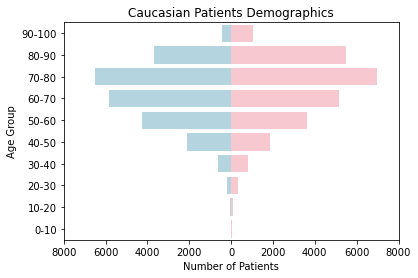

In [15]:
c_dem = pd.DataFrame({'Age': ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100'], 
                    'Male': [-22, -72, -191, -612, -2116, -4247, -5854, -6513, -3707, -457], 
                    'Female': [28, 113, 334, 784, 1858, 3631, 5159, 6976, 5488, 1033]})

AgeClass = ['90-100','80-90','70-80','60-70','50-60','40-50','30-40','20-30','10-20','0-10']

ax = sns.barplot(x='Male', y='Age', data=c_dem, order=AgeClass, color = 'lightblue')
ax = sns.barplot(x='Female', y='Age', data=c_dem, order=AgeClass, color = 'pink')

ax.set(xlabel="Number of Patients", ylabel="Age Group", title = "Caucasian Patients Demographics")
ticks = ax.get_xticks()
ax.set_xticklabels([int(abs(tick)) for tick in ticks])
plt.xlim([-8000, 8000])
use_index=False

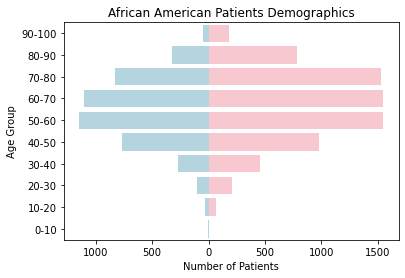

In [16]:
aa_dem = pd.DataFrame({'Age': ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100'], 
                    'Male': [-2, -32, -102, -275, -766, -1149, -1107, -833, -325, -48], 
                    'Female': [2, 62, 211, 459, 976, 1548, 1542, 1526, 786, 185]})

AgeClass = ['90-100','80-90','70-80','60-70','50-60','40-50','30-40','20-30','10-20','0-10']

ax = sns.barplot(x='Male', y='Age', data=aa_dem, order=AgeClass, color = 'lightblue')
ax = sns.barplot(x='Female', y='Age', data=aa_dem, order=AgeClass, color = 'pink')

ax.set(xlabel="Number of Patients", ylabel="Age Group", title = "African American Patients Demographics")
ticks = ax.get_xticks()
ax.set_xticklabels([int(abs(tick)) for tick in ticks])
use_index=False

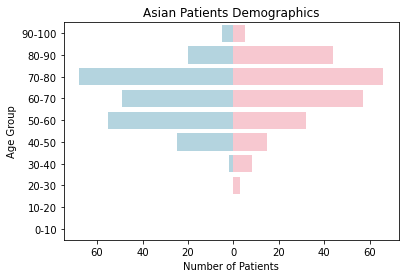

In [17]:
a_dem = pd.DataFrame({'Age': ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100'], 
                    'Male': [0, 0, 0, -2, -25, -55, -49, -68, -20, -5], 
                    'Female': [0, 0, 3, 8, 15, 32, 57, 66, 44, 5]})

AgeClass = ['90-100','80-90','70-80','60-70','50-60','40-50','30-40','20-30','10-20','0-10']

ax = sns.barplot(x='Male', y='Age', data=a_dem, order=AgeClass, color = 'lightblue')
ax = sns.barplot(x='Female', y='Age', data=a_dem, order=AgeClass, color = 'pink')

ax.set(xlabel="Number of Patients", ylabel="Age Group", title = "Asian Patients Demographics")
ticks = ax.get_xticks()
ax.set_xticklabels([int(abs(tick)) for tick in ticks])
use_index=False

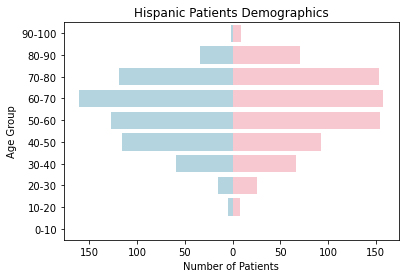

In [18]:
h_dem = pd.DataFrame({'Age': ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100'], 
                    'Male': [0, -5, -15, -59, -116, -127, -161, -119, -34, -2], 
                    'Female': [0, 8, 26, 67, 93, 155, 158, 154, 71, 9]})

AgeClass = ['90-100','80-90','70-80','60-70','50-60','40-50','30-40','20-30','10-20','0-10']

ax = sns.barplot(x='Male', y='Age', data=h_dem, order=AgeClass, color = 'lightblue')
ax = sns.barplot(x='Female', y='Age', data=h_dem, order=AgeClass, color = 'pink')

ax.set(xlabel="Number of Patients", ylabel="Age Group", title = "Hispanic Patients Demographics")
ticks = ax.get_xticks()
ax.set_xticklabels([int(abs(tick)) for tick in ticks])
use_index=False

<br>

## What are the diseases that tend to be co-morbid with diabetes?

In [19]:
#isolate the 20 most frequent diagnosis types from the first, second and third diagnoses

d1 = pd.DataFrame(round(enc['diag_1'].value_counts()))
d1 = d1.head(20)
d1.index.names = ['Type']
d1.columns = ['Count in Diagnosis 1']

d2 = pd.DataFrame(round(enc['diag_2'].value_counts()))
d2 = d2.head(20)
d2.index.names = ['Type']
d2.columns = ['Count in Diagnosis 2']

d3 = pd.DataFrame(round(enc['diag_3'].value_counts()))
d3 = d3.head(20)
d3.index.names = ['Type']
d3.columns = ['Count in Diagnosis 3']

In [20]:
#concatenate df for plotting
stack1 = pd.concat([d1, d2], axis=1)
stack2 = pd.concat([stack1, d3], axis=1)

#select only the types that recur across all three diagnoses
stack3 = stack2.dropna()
stack4 = stack3.reset_index()

#apply ICD-9 diagnosis labels from http://www.icd9data.com/2015/Volume1/default.htm

stack4.insert(1, "Type Name", ['Fluid electrolyte and acid-base imbalance', 'Chronic ischemic heart disease',
                              'Cardiac dysrhythmias', 'Heart failure', 'Acute kidney failure', 
                               'Urethra and urinary tract disorders', 'General Symptoms'], True) 

stack5 = stack4.drop(['Type'], axis=1)
stack5.set_index('Type Name', inplace=True)
stack5

,Count in Diagnosis 1,Count in Diagnosis 2,Count in Diagnosis 3
Type Name,,,
Fluid electrolyte and acid-base imbalance,1731.0,6223.0,5010.0
Chronic ischemic heart disease,5919.0,2153.0,3456.0
Cardiac dysrhythmias,2510.0,4677.0,3758.0
Heart failure,6463.0,6312.0,4391.0
Acute kidney failure,1446.0,1590.0,921.0
Urethra and urinary tract disorders,1514.0,3072.0,1841.0
General Symptoms,1828.0,1348.0,1255.0


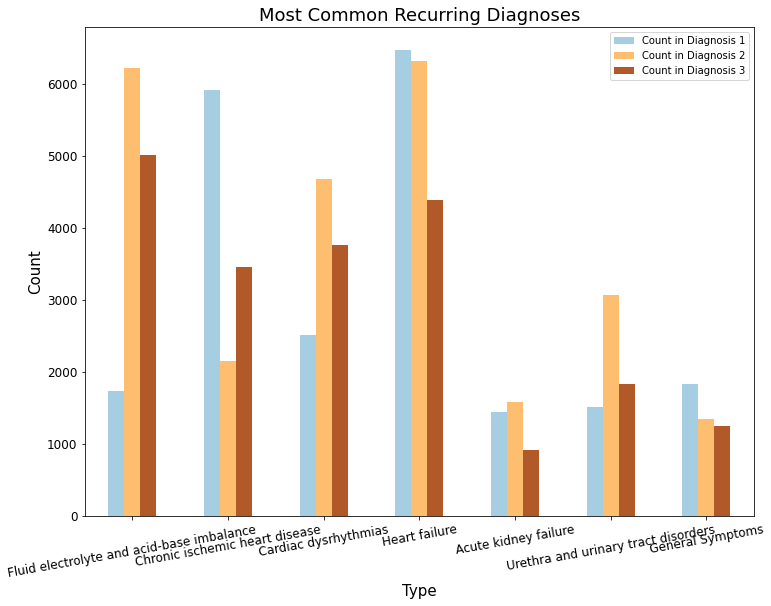

In [21]:
stack5.plot(kind='bar', stacked=False, figsize=(12, 9), cmap="Paired")
plt.title("Most Common Recurring Diagnoses", fontsize=18)
plt.xlabel("Type", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.xticks(rotation=10, fontsize=12)
plt.yticks(fontsize=12)
use_index=False

<br>

## Which demographics have higher morality rates?

In [22]:
#select visits that resulted in the worst case scenario, i.e. the death of the patient
array = [11, 19, 20, 21]
death = enc.loc[enc['discharge_dispo'].isin(array)]
deaths = death[['race', 'gender', 'age', 'discharge_dispo']]
deaths

,race,gender,age,discharge_dispo
27,Caucasian,Female,70-80,11
36,Caucasian,Female,80-90,11
64,Caucasian,Female,50-60,11
83,Caucasian,Male,70-80,11
84,Caucasian,Female,60-70,11
...,...,...,...,...
89401,Caucasian,Female,60-70,19
89535,Asian,Male,80-90,11
89547,Caucasian,Female,70-80,11
89579,Caucasian,Female,80-90,11


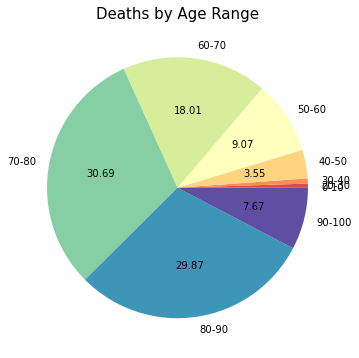

In [23]:
#age 
deaths_age = deaths.groupby('age').size()

def my_autopct(pct):
    return ('%.2f' % pct) if pct > 3 else ''

deaths_age.plot(kind='pie', subplots=True, figsize=(6, 6), autopct=my_autopct, cmap="Spectral")
rcParams['font.size'] = 8
plt.title("Deaths by Age Range", fontsize=15)
plt.ylabel("")
plt.show()

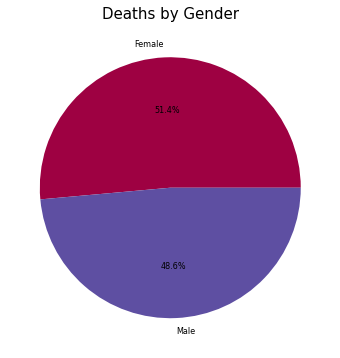

In [24]:
#gender
deaths_gen = deaths.groupby('gender').size()

deaths_gen.plot(kind='pie', subplots=True, figsize=(6, 6), autopct='%1.1f%%', cmap="Spectral")
plt.title("Deaths by Gender", fontsize=15)
plt.ylabel("")
plt.show()

<br>

## Is there demographic bias in the care received?

In [25]:
#subset df
procedures = enc[['race', 'num_lab_procedures', 'num_meds', 'days_hospital']]

#procedures for Caucasian patients
C = procedures.loc[(procedures['race'] =='Caucasian')]
C.describe()

#procedures for African American patients
AA = procedures.loc[(procedures['race'] =='AfricanAmerican')]
AA.describe()

#procedures for Asian patients
A = procedures.loc[(procedures['race'] =='Asian')]
A.describe()

#procedures for Hispanic patients
H = procedures.loc[(procedures['race'] =='Hispanic')]
H.describe()

# create df of averages
care = pd.DataFrame({
'Race': ['Caucasian','African American','Asian', 'Hispanic'],
'Average # Lab Procedures': [43.4, 44.5, 41.7, 43.4],
'Average # of Medications': [16.5, 15.6, 13.6, 14.2],
'Average # Days in Hospital': [4.4, 4.5, 4, 4.1]})

care

,Race,Average # Lab Procedures,Average # of Medications,Average # Days in Hospital
0,Caucasian,43.4,16.5,4.4
1,African American,44.5,15.6,4.5
2,Asian,41.7,13.6,4.0
3,Hispanic,43.4,14.2,4.1


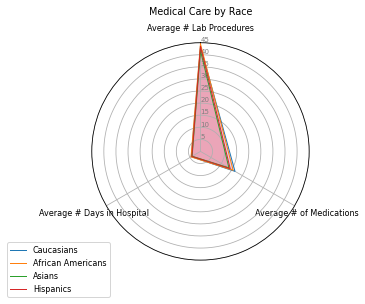

In [26]:
#create spider plot / radar plot

categories=list(care)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([5, 10, 15, 20, 25, 30, 35, 40, 45], ["5", "10", "15", "20", "25", "30", "35", "40", "45"], color="grey", size=7)
plt.ylim(0,45)

#lines
values=care.loc[0].drop('Race').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Caucasians")
ax.fill(angles, values, 'b', alpha=0.1)

values=care.loc[1].drop('Race').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="African Americans")
ax.fill(angles, values, 'r', alpha=0.1)

values=care.loc[2].drop('Race').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Asians")
ax.fill(angles, values, 'r', alpha=0.1)

values=care.loc[3].drop('Race').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Hispanics")
ax.fill(angles, values, 'r', alpha=0.1)

plt.title("Medical Care by Race", y=1.1)
plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))
use_index=False

<br>

## Does a longer hospital stay reduce later readmission?

In [27]:
#create smaller dfs
hos = enc[['days_hospital', 'readmit']]

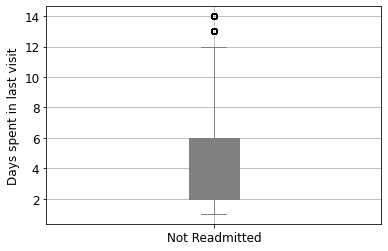

In [28]:
#not readmitted

Not = hos.loc[(hos['readmit'] == 'NO')]
Not = Not.rename(columns={'days_hospital':'Not Readmitted'})

boxplot = Not.boxplot(column=['Not Readmitted'], color='grey', patch_artist = True, fontsize = 12)
plt.ylabel("Days spent in last visit", fontsize = 12)
use_index=False

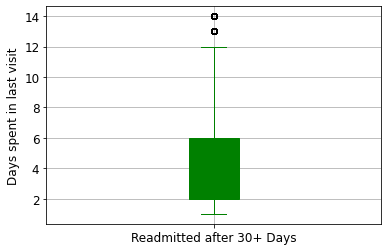

In [29]:
#readmitted after more than 30 days

After_30_Days = hos.loc[(hos['readmit'] == '>30')]
After_30_Days = After_30_Days.rename(columns={'days_hospital':'Readmitted after 30+ Days'})

boxplot = After_30_Days.boxplot(column=['Readmitted after 30+ Days'], color='green', patch_artist = True, fontsize = 12)
plt.ylabel("Days spent in last visit", fontsize = 12)
use_index=False

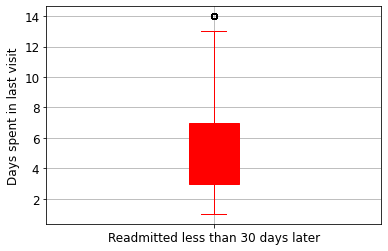

In [30]:
#readmitted less than 30 days later

Less_30_Days = hos.loc[(hos['readmit'] == '<30')]
Less_30_Days = Less_30_Days.rename(columns={'days_hospital':'Readmitted less than 30 days later'})

boxplot = Less_30_Days.boxplot(column=['Readmitted less than 30 days later'], color='red', patch_artist = True, fontsize = 12)
plt.ylabel("Days spent in last visit", fontsize = 12)
use_index=False

## What do the records of the "most problematic" patients look like?

In [31]:
#patient numbers and number of medications prescribed

meds = enc[['patient_nbr', 'num_meds']]

In [32]:
# the top 10 patients by number of visits

meds.patient_nbr.value_counts().nlargest(10)

88785891    27
23199021    23
1660293     23
88227540    23
84428613    22
92709351    20
90609804    20
29903877    20
37096866    20
88789707    19
Name: patient_nbr, dtype: int64

In [33]:
#creating lists for the top 10 patients

pat_88785891 = meds.loc[(meds['patient_nbr'] == 88785891)]
pat_88785891.reset_index(drop=True)
one = pat_88785891["num_meds"].tolist()

pat_23199021 = meds.loc[(meds['patient_nbr'] == 23199021)]
pat_23199021.reset_index(drop=True)
two = pat_23199021["num_meds"].tolist()

pat_1660293 = meds.loc[(meds['patient_nbr'] == 1660293)]
pat_1660293.reset_index(drop=True)
three = pat_1660293["num_meds"].tolist()

pat_88227540 = meds.loc[(meds['patient_nbr'] == 88227540)]
pat_88227540.reset_index(drop=True)
four = pat_88227540["num_meds"].tolist()

pat_84428613 = meds.loc[(meds['patient_nbr'] == 84428613)]
pat_84428613.reset_index(drop=True)
five = pat_84428613["num_meds"].tolist()

pat_92709351 = meds.loc[(meds['patient_nbr'] == 92709351)]
pat_92709351.reset_index(drop=True)
six = pat_92709351["num_meds"].tolist()

pat_90609804 = meds.loc[(meds['patient_nbr'] == 90609804)]
pat_90609804.reset_index(drop=True)
seven = pat_90609804["num_meds"].tolist()

pat_29903877 = meds.loc[(meds['patient_nbr'] == 29903877)]
pat_29903877.reset_index(drop=True)
eight = pat_29903877["num_meds"].tolist()

pat_37096866 = meds.loc[(meds['patient_nbr'] == 37096866)]
pat_37096866.reset_index(drop=True)
nine = pat_37096866["num_meds"].tolist()

pat_88789707 = meds.loc[(meds['patient_nbr'] == 88789707)]
pat_88789707.reset_index(drop=True)
ten = pat_88789707["num_meds"].tolist()

In [34]:
#creating a nested list

nest = [one, two, three, four, five, six, seven, eight, nine, ten]

In [35]:
#creating a dataframe

nested = pd.DataFrame(nest, ['Patient One', 'Patient Two', 'Patient Three', 'Patient Four', 'Patient Five',
                            'Patient Six', 'Patient Seven', 'Patient Eight', 'Patient Nine', 'Patient Ten']).T
nested.index.name = 'Visit'
nested = nested.shift()[1:]
nested

,Patient One,Patient Two,Patient Three,Patient Four,Patient Five,Patient Six,Patient Seven,Patient Eight,Patient Nine,Patient Ten
Visit,,,,,,,,,,
1,10.0,15.0,19.0,8.0,16.0,27.0,14.0,20.0,22.0,18.0
2,8.0,19.0,14.0,9.0,16.0,21.0,14.0,30.0,43.0,17.0
3,14.0,9.0,23.0,11.0,23.0,16.0,18.0,22.0,35.0,18.0
4,7.0,13.0,27.0,5.0,21.0,23.0,14.0,21.0,20.0,13.0
5,13.0,12.0,16.0,18.0,18.0,17.0,14.0,24.0,26.0,16.0
6,22.0,16.0,13.0,9.0,25.0,17.0,24.0,20.0,3.0,36.0
7,15.0,13.0,18.0,14.0,15.0,13.0,14.0,13.0,23.0,21.0
8,19.0,25.0,26.0,10.0,17.0,19.0,19.0,25.0,27.0,16.0
9,12.0,18.0,19.0,30.0,14.0,14.0,15.0,21.0,34.0,10.0


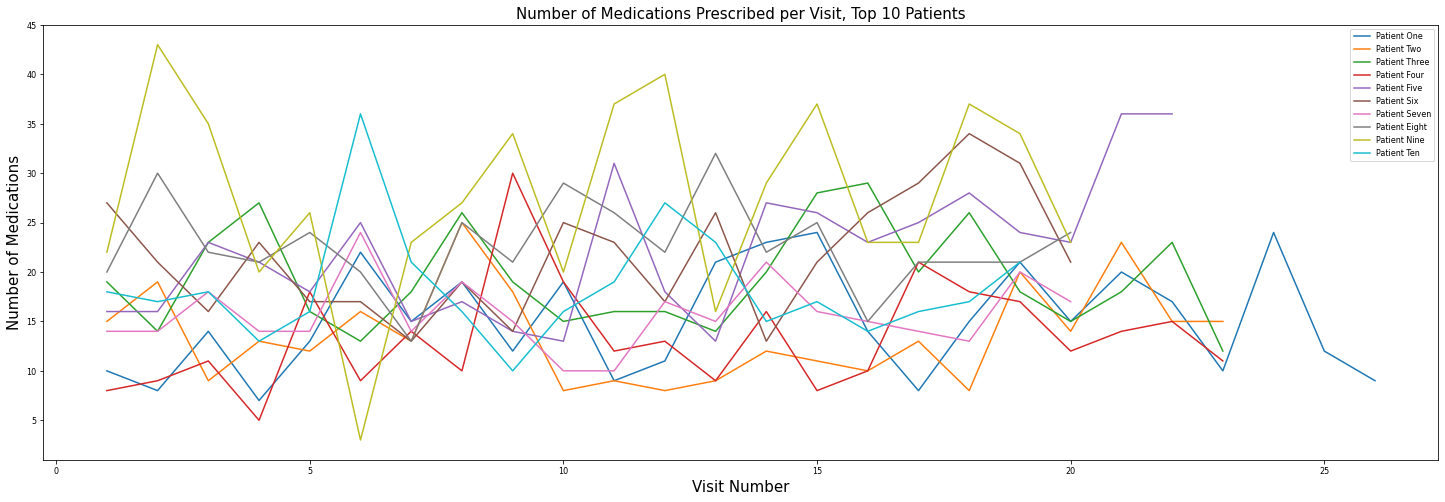

In [36]:
nested.plot(kind='line', figsize=(25,8))
plt.title("Number of Medications Prescribed per Visit, Top 10 Patients", fontsize=15)
plt.xlabel("Visit Number", fontsize=15)
plt.ylabel("Number of Medications", fontsize=15)
use_index=False

## 4. Conclusion <a id='four'></a>

**Q: Which demographic groups are overrepresented among diabetes patients?**

The dataset contained many more Caucasian patients than patients from other races, so a conclusion on race cannot be drawn.<br> However, 50-60 is the age range across all race groups where there is an obvious increase in the number of patients, only leveling off after 80, most likely due to death from old age or other reasons.

**Q: What are the diseases that tend to be co-morbid with diabetes?**

Diseases related to the cardiac, urinary and body fluid PH levels.

**Q: Which demographics have higher morality rates??**

There is an increase in the number of deaths among patients over 60 years old, increasing every decade until years 80-90. <br> Women are only slightly more likely to die than men.

**Q: Is there demographic bias in the care received?**

Surprisingly, that does not seem to be the case.<br>
The patients all received very similar numbers of lab procedures, medications, and stayed for roughly the same amount of days in the hospital. 

**Q: Does a longer hospital stay reduce later readmission?**

No, the reverse situation seems to be true.<br>
Patients who were not readmitted or only readmitted 30 days after the last visit had spent similar days in the hospital, but patients who stayed longer last time also came in much sooner after being discharged.<br>
It's more likely that the more severe the patients' diabetes is, the longer their stay, and the sooner they return.

**Q: What do the records of the "most problematic" patients look like?**

The number of medications prescribed to the top 10 patients does not plateau or lower over time - this indicates that their condition was constantly changing rather than being stabilized.

## 5. Publications <a id='five'></a>

To find this project on GitHub, please click [here](https://github.com/tapatia/dats6103_p3) for the repository and here for Github.io.<br>To find this project on Zenodo, please click [here](https://zenodo.org/record/4323345#.X9kCa-lKjVo). 

[RETURN TO TOP](#top)